# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Read the CSV and Perform Basic Data Cleaning

In [3]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [4]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [5]:
df_binary_encoded =  pd.get_dummies(df, columns=['home_ownership','verification_status','pymnt_plan','initial_list_status','application_type'])
df_binary_encoded

,loan_amnt,int_rate,installment,annual_inc,issue_d,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,...,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,pymnt_plan_n,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App
0,10500.0,0.1719,375.35,66000.0,Mar-2019,low_risk,27.24,0.0,0.0,8.0,...,0,1,0,1,0,1,0,1,1,0
1,25000.0,0.2000,929.09,105000.0,Mar-2019,low_risk,20.23,0.0,0.0,17.0,...,0,0,0,0,1,1,0,1,1,0
2,20000.0,0.2000,529.88,56000.0,Mar-2019,low_risk,24.26,0.0,0.0,8.0,...,0,0,0,0,1,1,0,1,1,0
3,10000.0,0.1640,353.55,92000.0,Mar-2019,low_risk,31.44,0.0,1.0,10.0,...,0,1,0,0,1,1,0,1,1,0
4,22000.0,0.1474,520.39,52000.0,Mar-2019,low_risk,18.76,0.0,1.0,14.0,...,0,0,1,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,26000.0,Jan-2019,low_risk,9.60,0.0,0.0,9.0,...,0,1,0,1,0,1,0,1,1,0
68813,12000.0,0.2727,368.37,63000.0,Jan-2019,low_risk,29.07,0.0,0.0,8.0,...,0,1,1,0,0,1,0,1,1,0
68814,5000.0,0.1992,185.62,52000.0,Jan-2019,low_risk,14.86,0.0,0.0,5.0,...,0,0,0,1,0,1,0,1,1,0
68815,40000.0,0.0646,1225.24,520000.0,Jan-2019,low_risk,9.96,0.0,1.0,21.0,...,0,0,0,0,1,1,1,0,1,0


In [6]:
# Months dictionary 
# Small dictionary due to values in data. Would change to break out month and year if dataset encompassed a larger range.
months_num = {
    "Jan-2019": 1,
    "Feb-2019": 2,
    "Mar-2019": 3,
    "Apr-2019": 4,
    "May-2019": 5
}


In [7]:
df_binary_encoded["issued_month_num"] = df_binary_encoded["issue_d"].apply(lambda x: months_num[x])
df_binary_encoded['next_pymnt_month_num'] = df_binary_encoded["next_pymnt_d"].apply(lambda x: months_num[x])
df_binary_encoded[["issue_d", "next_pymnt_d","issued_month_num", 'next_pymnt_month_num']]

,issue_d,next_pymnt_d,issued_month_num,next_pymnt_month_num
0,Mar-2019,May-2019,3,5
1,Mar-2019,May-2019,3,5
2,Mar-2019,May-2019,3,5
3,Mar-2019,May-2019,3,5
4,Mar-2019,May-2019,3,5
...,...,...,...,...
68812,Jan-2019,May-2019,1,5
68813,Jan-2019,May-2019,1,5
68814,Jan-2019,May-2019,1,5
68815,Jan-2019,May-2019,1,5


In [8]:
df_binary_encoded[['hardship_flag','debt_settlement_flag']].value_counts()

hardship_flag  debt_settlement_flag
N              N                       68817
dtype: int64

In [9]:
# Can drop hardship_flag and debt_settlement_flag since all records have the same value

df_binary_encoded = df_binary_encoded.drop(["issue_d", "next_pymnt_d", "hardship_flag", "debt_settlement_flag"], axis=1)
df_binary_encoded


,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,pymnt_plan_n,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,issued_month_num,next_pymnt_month_num
0,10500.0,0.1719,375.35,66000.0,low_risk,27.24,0.0,0.0,8.0,0.0,...,0,1,0,1,0,1,1,0,3,5
1,25000.0,0.2000,929.09,105000.0,low_risk,20.23,0.0,0.0,17.0,1.0,...,0,0,1,1,0,1,1,0,3,5
2,20000.0,0.2000,529.88,56000.0,low_risk,24.26,0.0,0.0,8.0,0.0,...,0,0,1,1,0,1,1,0,3,5
3,10000.0,0.1640,353.55,92000.0,low_risk,31.44,0.0,1.0,10.0,1.0,...,0,0,1,1,0,1,1,0,3,5
4,22000.0,0.1474,520.39,52000.0,low_risk,18.76,0.0,1.0,14.0,0.0,...,1,0,0,1,0,1,1,0,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,26000.0,low_risk,9.60,0.0,0.0,9.0,0.0,...,0,1,0,1,0,1,1,0,1,5
68813,12000.0,0.2727,368.37,63000.0,low_risk,29.07,0.0,0.0,8.0,0.0,...,1,0,0,1,0,1,1,0,1,5
68814,5000.0,0.1992,185.62,52000.0,low_risk,14.86,0.0,0.0,5.0,1.0,...,0,1,0,1,0,1,1,0,1,5
68815,40000.0,0.0646,1225.24,520000.0,low_risk,9.96,0.0,1.0,21.0,0.0,...,0,0,1,1,1,0,1,0,1,5


# Split the Data into Training and Testing

In [10]:
# Create our features
x_cols = [i for i in df_binary_encoded.columns if i not in ('loan_status')]
X = df_binary_encoded[x_cols]

# Create our target
y = df_binary_encoded[target]

In [11]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,pymnt_plan_n,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,issued_month_num,next_pymnt_month_num
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.478007,0.373992,0.148001,1.0,0.123879,0.876121,0.860340,0.139660,1.726172,4.616839
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.499520,0.483865,0.355104,0.0,0.329446,0.329446,0.346637,0.346637,0.743862,0.486161
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000,1.000000,4.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000,2.000000,5.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,1.000000,1.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000,2.000000,5.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3.000000,5.000000


In [12]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [14]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({'loan_status': 1})

In [15]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [16]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6513272907038131

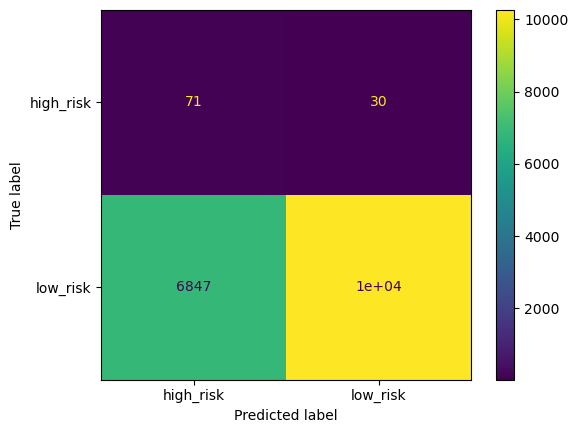

In [17]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()

In [18]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.70      0.60      0.02      0.65      0.43       101
   low_risk       1.00      0.60      0.70      0.75      0.65      0.42     17104

avg / total       0.99      0.60      0.70      0.74      0.65      0.42     17205



### SMOTE Oversampling

In [19]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(
    X_train, y_train
)
Counter(y_resampled)

Counter({'loan_status': 1})

In [20]:
# Train the Logistic Regression model using the resampled data
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [21]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6727359242004649

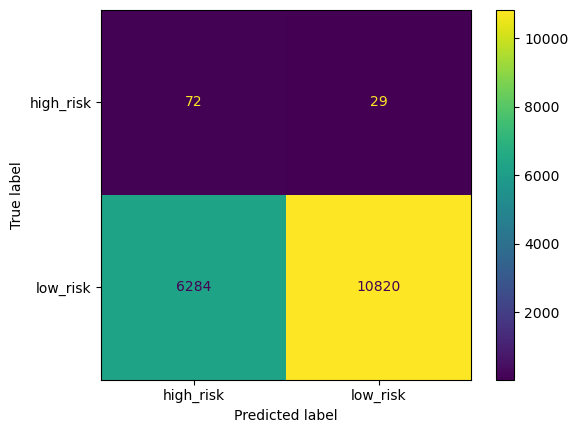

In [22]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()

In [23]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.71      0.63      0.02      0.67      0.45       101
   low_risk       1.00      0.63      0.71      0.77      0.67      0.45     17104

avg / total       0.99      0.63      0.71      0.77      0.67      0.45     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [24]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'loan_status': 1})

In [25]:
# Train the Logistic Regression model using the resampled data
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [26]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5375999129379729

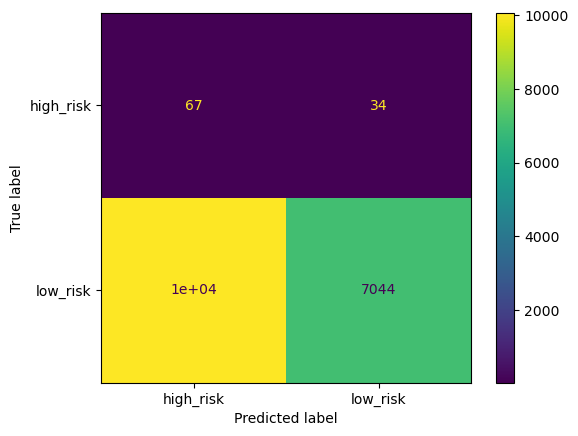

In [27]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()

In [28]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.66      0.41      0.01      0.52      0.28       101
   low_risk       1.00      0.41      0.66      0.58      0.52      0.27     17104

avg / total       0.99      0.41      0.66      0.58      0.52      0.27     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [29]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.combine import SMOTEENN 
sme = SMOTEENN(random_state=1)
X_resampled, y_resampled = sme.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'loan_status': 1})

In [30]:
# Train the Logistic Regression model using the resampled data
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [31]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6475663732182386

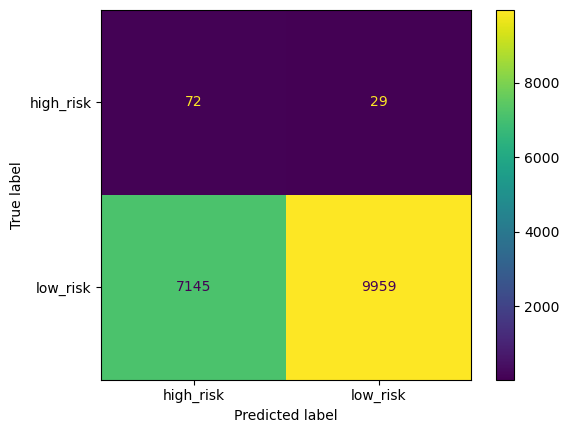

In [32]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()

In [33]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.71      0.58      0.02      0.64      0.42       101
   low_risk       1.00      0.58      0.71      0.74      0.64      0.41     17104

avg / total       0.99      0.58      0.71      0.73      0.64      0.41     17205

